In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.datasets.cifar10 import load_data

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
epochs_completed = 0
index_in_epoch = 0
num_examples = x_train.shape[0]
    # for splitting out batches of data
def next_batch(batch_size):

    global x_train
    global y_train
    global index_in_epoch
    global epochs_completed

    start = index_in_epoch
    index_in_epoch += batch_size

    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return x_train[start:end], y_train[start:end]

In [4]:
total_epoch = 200
batch_size = 100
n_noise = 100

D_global_step = tf.Variable(0, trainable=False, name='D_global_step')
G_global_step = tf.Variable(0, trainable=False, name='G_global_step')

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Z = tf.placeholder(tf.float32, [None, n_noise])
is_training = tf.placeholder(tf.bool)

In [5]:
# def generator(noise):
#     with tf.variable_scope('generator'):
#         output = tf.layers.dense(noise, 8*8*256)
# #         output = tf.nn.relu(tf.reshape(output, [-1, 2, 2, 256]))
#         output = tf.reshape(output, [-1, 8, 8, 256])
#         output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
#         output = tf.layers.conv2d_transpose(output, 128, [5, 5], strides=(2, 2), padding='SAME')
#         output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
#         output = tf.layers.conv2d_transpose(output, 64, [5, 5], strides=(2, 2), padding='SAME')
#         output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
#         output = tf.layers.conv2d_transpose(output, 32, [5, 5], strides=(2, 2), padding='SAME')
#         output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
#         output = tf.layers.conv2d_transpose(output, 3, [5, 5], strides=(2, 2), padding='SAME')
#         output = tf.nn.tanh(output)
#     return output

# def discriminator(inputs, reuse=None):
#     with tf.variable_scope('discriminator') as scope:
#         if reuse:
#             scope.reuse_variables()
#         output = tf.reshape(inputs, [-1, 32, 32, 3])
#         output = tf.layers.conv2d(inputs, 32, [5,5], strides=(2,2),padding='SAME')
#         output = tf.nn.leaky_relu(tf.layers.batch_normalization(output,training=is_training))
#         output = tf.layers.conv2d(output, 64, [5,5], strides=(2,2),padding='SAME')
#         output = tf.nn.leaky_relu(tf.layers.batch_normalization(output,training=is_training))
#         output = tf.layers.conv2d(output, 128, [5,5], strides=(2,2), padding='SAME')
#         output = tf.nn.leaky_relu(tf.layers.batch_normalization(output, training=is_training))
#         output = tf.layers.conv2d(output, 256, [5,5], strides=(2,2),padding='SAME')
#         output = tf.nn.leaky_relu(tf.layers.batch_normalization(output,training=is_training))
#         flat = tf.contrib.layers.flatten(output)
#         output = tf.layers.dense(flat, 1)
# #         output = tf.nn.sigmoid(output)
#     return output
def generator(noise):
    with tf.variable_scope('generator'):
        output = tf.layers.dense(noise, 2*2*512)
        output = tf.reshape(output, [-1, 2, 2, 512])
        output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d_transpose(output, 256, [5, 5], strides=(2, 2), padding='SAME')
        output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d_transpose(output, 128, [5, 5], strides=(2, 2), padding='SAME')
        output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d_transpose(output, 64, [5, 5], strides=(2, 2), padding='SAME')
        output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d_transpose(output, 3, [5, 5], strides=(2, 2), padding='SAME')
#         output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.nn.tanh(output)
    return output

def discriminator(inputs, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        output = tf.reshape(inputs, [-1, 32, 32, 3])
        output = tf.layers.conv2d(inputs, 64, [5,5], strides=(2,2),padding='SAME')
        output = tf.nn.leaky_relu(tf.layers.batch_normalization(output,training=is_training))
        output = tf.layers.conv2d(output, 128, [5,5], strides=(2,2),padding='SAME')
        output = tf.nn.leaky_relu(tf.layers.batch_normalization(output,training=is_training))
        output = tf.layers.conv2d(output, 256, [5,5], strides=(2,2), padding='SAME')
        output = tf.nn.leaky_relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d(output, 512, [5,5], strides=(2,2), padding='SAME')
        output = tf.nn.leaky_relu(tf.layers.batch_normalization(output, training=is_training))
        flat = tf.contrib.layers.flatten(output)
        output = tf.layers.dense(flat, 1, activation=None)
    return output                                           

In [6]:
def get_noise(batch_size, n_noise):
    return np.random.uniform(-1, 1, size=[batch_size, n_noise])

In [7]:
G = generator(Z)
D_real = discriminator(X)
D_gene = discriminator(G, True)

In [8]:
# loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene))
# loss_G = tf.reduce_mean(tf.log(D_gene))
loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_real, labels=tf.ones_like(D_real)
))
loss_D_gene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.zeros_like(D_gene)
))
 
    
loss_D = loss_D_real + loss_D_gene
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.ones_like(D_gene)
))

In [9]:
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list = vars_D, global_step=D_global_step)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list = vars_G, global_step=G_global_step)

Epoch: 0000 D loss: 0.08059 G loss: 5.298
Epoch: 0001 D loss: 0.0561 G loss: 5.075
Epoch: 0002 D loss: 0.1803 G loss: 4.481
Epoch: 0003 D loss: 4.46 G loss: 23.89
Epoch: 0004 D loss: 0.002423 G loss: 9.047
Epoch: 0005 D loss: 0.07291 G loss: 14.69
Epoch: 0006 D loss: 0.01538 G loss: 10.71


KeyboardInterrupt: 

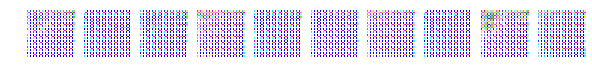

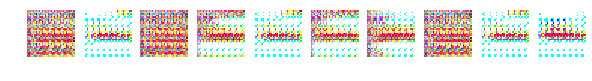

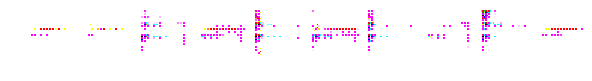

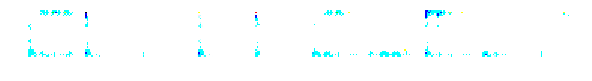

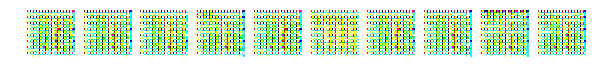

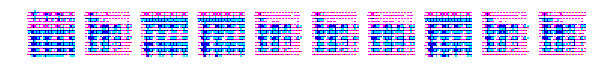

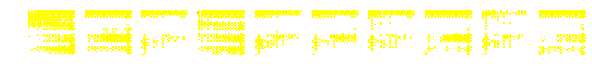

In [10]:
tf.summary.scalar('loss_D', loss_D)
tf.summary.scalar('loss_G', loss_G)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
#     merged = tf.summary.merge_all()
#     writer = tf.summary.FileWriter('./DCGAN_logs', sess.graph)
    
    total_batch = int(len(x_train) / batch_size)
    
    for epoch in range(total_epoch):
        for i in range(total_batch):
            
            batch_xs, _ = next_batch(batch_size)
            batch_xs = batch_xs / 255
            batch_xs = batch_xs.reshape(-1, 32, 32, 3)
            noise = get_noise(batch_size, n_noise)

            _, loss_val_D = sess.run([train_D, loss_D], feed_dict={X:batch_xs, Z:noise, is_training:True})
            _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Z:noise, is_training: True})
        
#         summary = sess.run(merged, feed_dict={X:batch_xs, Z:noise, is_training:True})
#         writer.add_summary(summary, global_step=sess.run(G_global_step))

#         if epoch == 0 or (epoch + 1) % 5 == 0:
        print('Epoch:', '%04d'%epoch, 'D loss: {:.4}'.format(loss_val_D), 'G loss: {:.4}'.format(loss_val_G))
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z:noise, is_training:False})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape((samples[i] * 255).astype(np.uint8), (32,32,3) ))
#                 ax[i].imshow(samples[i])

        plt.savefig('./DCGAN_CIFAR10/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')